In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from pathlib import Path
import pytorch_lightning as pl

c:\Users\aaron\Desktop\Programacion\proyecto_jic\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_dataset = Path("..\\datasets\\ASL\\ASL_train")
test_dataset = Path("..\\datasets\\ASL\ASL_test")

In [3]:
#transformar imagen
SIZE = 224
data_transform = transforms.Compose([
    transforms.Resize(size=(SIZE,SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [4]:
train_data = datasets.ImageFolder(root = train_dataset, transform = data_transform, target_transform = None)
test_data = datasets.ImageFolder(root = test_dataset, transform = data_transform)

In [5]:
#Check classes
class_dict = train_data.classes
class_dict


['A_ASL',
 'B_ASL',
 'C_ASL',
 'D_ASL',
 'E_ASL',
 'F_ASL',
 'G_ASL',
 'H_ASL',
 'I_ASL',
 'K_ASL',
 'L_ASL',
 'M_ASL',
 'N_ASL',
 'O_ASL',
 'P_ASL',
 'Q_ASL',
 'R_ASL',
 'S_ASL',
 'T_ASL',
 'U_ASL',
 'V_ASL',
 'W_ASL',
 'X_ASL',
 'Y_ASL']

In [6]:
'''from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset=train_data,batch_size=8,num_workers=4,shuffle=True)
test_dataloader = DataLoader(dataset=test_data,batch_size=8,num_workers=4,shuffle=True)'''

'from torch.utils.data import DataLoader\n\ntrain_dataloader = DataLoader(dataset=train_data,batch_size=8,num_workers=4,shuffle=True)\ntest_dataloader = DataLoader(dataset=test_data,batch_size=8,num_workers=4,shuffle=True)'

In [9]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([8, 3, 224, 224]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([8])


In [7]:
class ImageClassificationColator:
    def __init__(self,feature_extractor):
        self.feature_extractor = feature_extractor
    def __call__(self,batch):
        encondings = self.feature_extractor([x[0] for x in batch], return_tensors = "pt")
        encondings['labels'] = torch.tensor([x[1] for x in batch], dtype = torch.long)
        return encondings

BATCH_SIZE = 16
EPOCHS = 2
LEARNING_RATE = 2e-6

print(torch.cuda.current_device())
print(torch.cuda.is_available())


0
True


In [8]:
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification,ViTFeatureExtractor

feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224", do_rescale = False)
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224", ignore_mismatched_sizes=True, num_labels = len(class_dict), id2label = {str(i):c for i, c in enumerate(class_dict)},label2id =  {c : str(i) for i,c in enumerate(class_dict)})

collator = ImageClassificationColator(feature_extractor=feature_extractor)
train_dataloader = DataLoader(dataset=train_data,batch_size=BATCH_SIZE,num_workers=2,shuffle=True, collate_fn=collator)
test_dataloader = DataLoader(dataset=test_data,batch_size=BATCH_SIZE,num_workers=2,shuffle=True, collate_fn=collator)





c:\Users\aaron\Desktop\Programacion\proyecto_jic\.venv\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([24]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([24, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.nn import CrossEntropyLoss
from datasets import load_dataset, load_metric

accuracy_metric = load_metric('accuracy',trust_remote_code=True)

# Define compute metrics function
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    return accuracy

In [11]:
from transformers import TrainerCallback, EarlyStoppingCallback
from tqdm import tqdm

from transformers import Trainer,TrainingArguments
training_args = TrainingArguments(
    output_dir="..\model\d_50k2",
    use_cpu=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=LEARNING_RATE,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_dir="..\model\logs",
    logging_steps=50

)

trainer = Trainer(
    model = model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)


c:\Users\aaron\Desktop\Programacion\proyecto_jic\.venv\Lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [12]:

trainer.train()

  0%|          | 0/8326 [00:00<?, ?it/s]c:\Users\aaron\Desktop\Programacion\proyecto_jic\.venv\Lib\site-packages\transformers\models\vit\modeling_vit.py:253: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  context_layer = torch.nn.functional.scaled_dot_product_attention(
  1%|          | 50/8326 [00:23<1:01:53,  2.23it/s]

{'loss': 3.3098, 'grad_norm': 12.616619110107422, 'learning_rate': 1.987989430699015e-06, 'epoch': 0.01}


  1%|          | 100/8326 [00:45<1:01:19,  2.24it/s]

{'loss': 3.2187, 'grad_norm': 17.744779586791992, 'learning_rate': 1.97597886139803e-06, 'epoch': 0.02}


  2%|▏         | 150/8326 [01:08<1:01:05,  2.23it/s]

{'loss': 3.2482, 'grad_norm': 13.123552322387695, 'learning_rate': 1.9639682920970453e-06, 'epoch': 0.04}


  2%|▏         | 200/8326 [01:30<1:01:10,  2.21it/s]

{'loss': 3.1876, 'grad_norm': 13.524406433105469, 'learning_rate': 1.9519577227960605e-06, 'epoch': 0.05}


  3%|▎         | 250/8326 [01:53<1:00:18,  2.23it/s]

{'loss': 3.1505, 'grad_norm': 11.18923568725586, 'learning_rate': 1.9399471534950756e-06, 'epoch': 0.06}


  4%|▎         | 300/8326 [02:15<1:00:12,  2.22it/s]

{'loss': 3.1183, 'grad_norm': 10.975484848022461, 'learning_rate': 1.9279365841940908e-06, 'epoch': 0.07}


  4%|▍         | 350/8326 [02:38<1:00:28,  2.20it/s]

{'loss': 3.0742, 'grad_norm': 12.38478946685791, 'learning_rate': 1.915926014893106e-06, 'epoch': 0.08}


  5%|▍         | 400/8326 [03:01<59:49,  2.21it/s]  

{'loss': 3.0438, 'grad_norm': 11.842905044555664, 'learning_rate': 1.9039154455921208e-06, 'epoch': 0.1}


  5%|▌         | 450/8326 [03:24<59:13,  2.22it/s]  

{'loss': 3.02, 'grad_norm': 11.799230575561523, 'learning_rate': 1.891904876291136e-06, 'epoch': 0.11}


  6%|▌         | 500/8326 [03:47<59:42,  2.18it/s]  

{'loss': 3.0004, 'grad_norm': 12.425763130187988, 'learning_rate': 1.8798943069901511e-06, 'epoch': 0.12}


  7%|▋         | 550/8326 [04:10<59:57,  2.16it/s]  

{'loss': 2.9141, 'grad_norm': 12.638303756713867, 'learning_rate': 1.8678837376891663e-06, 'epoch': 0.13}


  7%|▋         | 600/8326 [04:33<58:29,  2.20it/s]  

{'loss': 2.9646, 'grad_norm': 11.080918312072754, 'learning_rate': 1.8558731683881814e-06, 'epoch': 0.14}


  8%|▊         | 650/8326 [04:55<58:02,  2.20it/s]

{'loss': 2.9215, 'grad_norm': 11.604284286499023, 'learning_rate': 1.8438625990871965e-06, 'epoch': 0.16}


  8%|▊         | 700/8326 [05:18<58:04,  2.19it/s]

{'loss': 2.8682, 'grad_norm': 11.45669937133789, 'learning_rate': 1.8318520297862119e-06, 'epoch': 0.17}


  9%|▉         | 750/8326 [05:41<57:09,  2.21it/s]

{'loss': 2.7749, 'grad_norm': 13.224526405334473, 'learning_rate': 1.819841460485227e-06, 'epoch': 0.18}


 10%|▉         | 800/8326 [06:04<57:16,  2.19it/s]

{'loss': 2.7839, 'grad_norm': 11.777373313903809, 'learning_rate': 1.8078308911842422e-06, 'epoch': 0.19}


 10%|█         | 850/8326 [06:27<56:39,  2.20it/s]

{'loss': 2.714, 'grad_norm': 15.273365020751953, 'learning_rate': 1.7958203218832573e-06, 'epoch': 0.2}


 11%|█         | 900/8326 [06:50<56:04,  2.21it/s]

{'loss': 2.7167, 'grad_norm': 11.313060760498047, 'learning_rate': 1.7838097525822725e-06, 'epoch': 0.22}


 11%|█▏        | 950/8326 [07:12<55:59,  2.20it/s]

{'loss': 2.6399, 'grad_norm': 12.044451713562012, 'learning_rate': 1.7717991832812876e-06, 'epoch': 0.23}


 12%|█▏        | 1000/8326 [07:35<55:00,  2.22it/s]

{'loss': 2.6411, 'grad_norm': 12.856673240661621, 'learning_rate': 1.7597886139803027e-06, 'epoch': 0.24}


 13%|█▎        | 1050/8326 [07:58<55:30,  2.18it/s]

{'loss': 2.5753, 'grad_norm': 12.331451416015625, 'learning_rate': 1.7477780446793179e-06, 'epoch': 0.25}


 13%|█▎        | 1100/8326 [08:20<54:34,  2.21it/s]

{'loss': 2.4891, 'grad_norm': 11.176734924316406, 'learning_rate': 1.7357674753783328e-06, 'epoch': 0.26}


 14%|█▍        | 1150/8326 [08:43<54:01,  2.21it/s]

{'loss': 2.489, 'grad_norm': 12.185894966125488, 'learning_rate': 1.723756906077348e-06, 'epoch': 0.28}


 14%|█▍        | 1200/8326 [09:06<53:28,  2.22it/s]

{'loss': 2.4531, 'grad_norm': 11.60882568359375, 'learning_rate': 1.711746336776363e-06, 'epoch': 0.29}


 15%|█▌        | 1250/8326 [09:29<53:26,  2.21it/s]

{'loss': 2.4176, 'grad_norm': 11.69792366027832, 'learning_rate': 1.6997357674753782e-06, 'epoch': 0.3}


 16%|█▌        | 1300/8326 [09:52<53:13,  2.20it/s]

{'loss': 2.3609, 'grad_norm': 12.259339332580566, 'learning_rate': 1.6877251981743934e-06, 'epoch': 0.31}


 16%|█▌        | 1350/8326 [10:15<52:05,  2.23it/s]

{'loss': 2.3266, 'grad_norm': 10.829553604125977, 'learning_rate': 1.6757146288734085e-06, 'epoch': 0.32}


 17%|█▋        | 1400/8326 [10:37<51:47,  2.23it/s]

{'loss': 2.2442, 'grad_norm': 14.400980949401855, 'learning_rate': 1.6637040595724237e-06, 'epoch': 0.34}


 17%|█▋        | 1450/8326 [11:00<51:48,  2.21it/s]

{'loss': 2.2486, 'grad_norm': 12.302961349487305, 'learning_rate': 1.6516934902714388e-06, 'epoch': 0.35}


 18%|█▊        | 1500/8326 [11:23<51:28,  2.21it/s]

{'loss': 2.2008, 'grad_norm': 12.249996185302734, 'learning_rate': 1.639682920970454e-06, 'epoch': 0.36}


 19%|█▊        | 1550/8326 [11:46<51:16,  2.20it/s]

{'loss': 2.1525, 'grad_norm': 12.431549072265625, 'learning_rate': 1.627672351669469e-06, 'epoch': 0.37}


 19%|█▉        | 1600/8326 [12:09<50:26,  2.22it/s]

{'loss': 2.0815, 'grad_norm': 11.454904556274414, 'learning_rate': 1.6156617823684842e-06, 'epoch': 0.38}


 20%|█▉        | 1650/8326 [12:32<50:21,  2.21it/s]

{'loss': 2.023, 'grad_norm': 13.544068336486816, 'learning_rate': 1.6036512130674994e-06, 'epoch': 0.4}


 20%|██        | 1700/8326 [12:55<49:31,  2.23it/s]

{'loss': 2.0138, 'grad_norm': 15.03232192993164, 'learning_rate': 1.5916406437665145e-06, 'epoch': 0.41}


 21%|██        | 1750/8326 [13:18<49:18,  2.22it/s]

{'loss': 1.9675, 'grad_norm': 13.337666511535645, 'learning_rate': 1.5796300744655294e-06, 'epoch': 0.42}


 22%|██▏       | 1800/8326 [13:40<48:56,  2.22it/s]

{'loss': 1.9245, 'grad_norm': 12.892212867736816, 'learning_rate': 1.5676195051645446e-06, 'epoch': 0.43}


 22%|██▏       | 1850/8326 [14:03<48:36,  2.22it/s]

{'loss': 1.8639, 'grad_norm': 12.198465347290039, 'learning_rate': 1.5556089358635597e-06, 'epoch': 0.44}


 23%|██▎       | 1900/8326 [14:26<48:34,  2.21it/s]

{'loss': 1.7707, 'grad_norm': 12.310067176818848, 'learning_rate': 1.5435983665625749e-06, 'epoch': 0.46}


 23%|██▎       | 1950/8326 [14:49<47:47,  2.22it/s]

{'loss': 1.7969, 'grad_norm': 11.206076622009277, 'learning_rate': 1.53158779726159e-06, 'epoch': 0.47}


 24%|██▍       | 2000/8326 [15:12<47:46,  2.21it/s]

{'loss': 1.7151, 'grad_norm': 10.859049797058105, 'learning_rate': 1.5195772279606051e-06, 'epoch': 0.48}


 25%|██▍       | 2050/8326 [15:34<47:14,  2.21it/s]

{'loss': 1.7525, 'grad_norm': 11.784483909606934, 'learning_rate': 1.5075666586596203e-06, 'epoch': 0.49}


 25%|██▌       | 2100/8326 [15:57<47:01,  2.21it/s]

{'loss': 1.6366, 'grad_norm': 12.496423721313477, 'learning_rate': 1.4955560893586356e-06, 'epoch': 0.5}


 26%|██▌       | 2150/8326 [16:20<46:43,  2.20it/s]

{'loss': 1.6173, 'grad_norm': 11.298802375793457, 'learning_rate': 1.4835455200576508e-06, 'epoch': 0.52}


 26%|██▋       | 2200/8326 [16:42<45:56,  2.22it/s]

{'loss': 1.5157, 'grad_norm': 11.02425479888916, 'learning_rate': 1.471534950756666e-06, 'epoch': 0.53}


 27%|██▋       | 2250/8326 [17:05<45:51,  2.21it/s]

{'loss': 1.5646, 'grad_norm': 21.879520416259766, 'learning_rate': 1.459524381455681e-06, 'epoch': 0.54}


 28%|██▊       | 2300/8326 [17:28<45:20,  2.22it/s]

{'loss': 1.527, 'grad_norm': 10.26709270477295, 'learning_rate': 1.4475138121546962e-06, 'epoch': 0.55}


 28%|██▊       | 2350/8326 [17:50<44:48,  2.22it/s]

{'loss': 1.4597, 'grad_norm': 13.066261291503906, 'learning_rate': 1.4355032428537113e-06, 'epoch': 0.56}


 29%|██▉       | 2400/8326 [18:13<45:09,  2.19it/s]

{'loss': 1.4095, 'grad_norm': 11.846488952636719, 'learning_rate': 1.4234926735527265e-06, 'epoch': 0.58}


 29%|██▉       | 2450/8326 [18:35<44:29,  2.20it/s]

{'loss': 1.411, 'grad_norm': 11.919336318969727, 'learning_rate': 1.4114821042517416e-06, 'epoch': 0.59}


 30%|███       | 2500/8326 [18:58<43:46,  2.22it/s]

{'loss': 1.408, 'grad_norm': 11.92116928100586, 'learning_rate': 1.3994715349507566e-06, 'epoch': 0.6}


 31%|███       | 2550/8326 [19:21<43:39,  2.21it/s]

{'loss': 1.3732, 'grad_norm': 11.373445510864258, 'learning_rate': 1.3874609656497717e-06, 'epoch': 0.61}


 31%|███       | 2600/8326 [19:43<43:01,  2.22it/s]

{'loss': 1.249, 'grad_norm': 12.202718734741211, 'learning_rate': 1.3754503963487868e-06, 'epoch': 0.62}


 32%|███▏      | 2650/8326 [20:06<42:44,  2.21it/s]

{'loss': 1.2585, 'grad_norm': 11.0055513381958, 'learning_rate': 1.363439827047802e-06, 'epoch': 0.64}


 32%|███▏      | 2700/8326 [20:28<42:21,  2.21it/s]

{'loss': 1.3008, 'grad_norm': 10.110153198242188, 'learning_rate': 1.3514292577468171e-06, 'epoch': 0.65}


 33%|███▎      | 2750/8326 [20:51<41:48,  2.22it/s]

{'loss': 1.268, 'grad_norm': 11.661395072937012, 'learning_rate': 1.3394186884458323e-06, 'epoch': 0.66}


 34%|███▎      | 2800/8326 [21:14<41:21,  2.23it/s]

{'loss': 1.171, 'grad_norm': 9.196738243103027, 'learning_rate': 1.3274081191448474e-06, 'epoch': 0.67}


 34%|███▍      | 2850/8326 [21:36<41:18,  2.21it/s]

{'loss': 1.1989, 'grad_norm': 8.999755859375, 'learning_rate': 1.3153975498438625e-06, 'epoch': 0.68}


 35%|███▍      | 2900/8326 [21:59<40:47,  2.22it/s]

{'loss': 1.2072, 'grad_norm': 10.890557289123535, 'learning_rate': 1.3033869805428777e-06, 'epoch': 0.7}


 35%|███▌      | 2950/8326 [22:21<40:24,  2.22it/s]

{'loss': 1.1589, 'grad_norm': 10.693281173706055, 'learning_rate': 1.2913764112418928e-06, 'epoch': 0.71}


 36%|███▌      | 3000/8326 [22:44<40:14,  2.21it/s]

{'loss': 1.137, 'grad_norm': 13.905579566955566, 'learning_rate': 1.279365841940908e-06, 'epoch': 0.72}


 37%|███▋      | 3050/8326 [23:07<39:30,  2.23it/s]

{'loss': 1.084, 'grad_norm': 10.02501106262207, 'learning_rate': 1.2673552726399231e-06, 'epoch': 0.73}


 37%|███▋      | 3100/8326 [23:29<39:32,  2.20it/s]

{'loss': 1.0875, 'grad_norm': 7.77345085144043, 'learning_rate': 1.2553447033389383e-06, 'epoch': 0.74}


 38%|███▊      | 3150/8326 [23:52<38:49,  2.22it/s]

{'loss': 1.0337, 'grad_norm': 10.361364364624023, 'learning_rate': 1.2433341340379532e-06, 'epoch': 0.76}


 38%|███▊      | 3200/8326 [24:14<38:27,  2.22it/s]

{'loss': 1.0164, 'grad_norm': 9.997836112976074, 'learning_rate': 1.2313235647369683e-06, 'epoch': 0.77}


 39%|███▉      | 3250/8326 [24:37<39:04,  2.16it/s]

{'loss': 1.0147, 'grad_norm': 10.684917449951172, 'learning_rate': 1.2193129954359835e-06, 'epoch': 0.78}


 40%|███▉      | 3300/8326 [25:00<38:31,  2.17it/s]

{'loss': 1.0127, 'grad_norm': 9.342531204223633, 'learning_rate': 1.2073024261349986e-06, 'epoch': 0.79}


 40%|████      | 3350/8326 [25:23<37:43,  2.20it/s]

{'loss': 0.9635, 'grad_norm': 8.898933410644531, 'learning_rate': 1.1952918568340137e-06, 'epoch': 0.8}


 41%|████      | 3400/8326 [25:46<37:20,  2.20it/s]

{'loss': 0.9667, 'grad_norm': 9.836783409118652, 'learning_rate': 1.1832812875330289e-06, 'epoch': 0.82}


 41%|████▏     | 3450/8326 [26:09<36:23,  2.23it/s]

{'loss': 0.958, 'grad_norm': 10.170899391174316, 'learning_rate': 1.171270718232044e-06, 'epoch': 0.83}


 42%|████▏     | 3500/8326 [26:31<36:08,  2.23it/s]

{'loss': 0.9115, 'grad_norm': 8.316452026367188, 'learning_rate': 1.1592601489310594e-06, 'epoch': 0.84}


 43%|████▎     | 3550/8326 [26:54<35:44,  2.23it/s]

{'loss': 0.9153, 'grad_norm': 8.844216346740723, 'learning_rate': 1.1472495796300745e-06, 'epoch': 0.85}


 43%|████▎     | 3600/8326 [27:17<35:39,  2.21it/s]

{'loss': 0.8732, 'grad_norm': 14.585493087768555, 'learning_rate': 1.1352390103290897e-06, 'epoch': 0.86}


 44%|████▍     | 3650/8326 [27:39<35:04,  2.22it/s]

{'loss': 0.8757, 'grad_norm': 7.281426429748535, 'learning_rate': 1.1232284410281048e-06, 'epoch': 0.88}


 44%|████▍     | 3700/8326 [28:02<34:49,  2.21it/s]

{'loss': 0.8831, 'grad_norm': 9.555270195007324, 'learning_rate': 1.11121787172712e-06, 'epoch': 0.89}


 45%|████▌     | 3750/8326 [28:25<34:18,  2.22it/s]

{'loss': 0.8475, 'grad_norm': 7.285068035125732, 'learning_rate': 1.099207302426135e-06, 'epoch': 0.9}


 46%|████▌     | 3800/8326 [28:47<34:03,  2.21it/s]

{'loss': 0.8635, 'grad_norm': 10.517098426818848, 'learning_rate': 1.0871967331251502e-06, 'epoch': 0.91}


 46%|████▌     | 3850/8326 [29:10<33:42,  2.21it/s]

{'loss': 0.7549, 'grad_norm': 5.610238075256348, 'learning_rate': 1.0751861638241654e-06, 'epoch': 0.92}


 47%|████▋     | 3900/8326 [29:33<33:19,  2.21it/s]

{'loss': 0.8042, 'grad_norm': 8.543763160705566, 'learning_rate': 1.0631755945231803e-06, 'epoch': 0.94}


 47%|████▋     | 3950/8326 [29:56<33:03,  2.21it/s]

{'loss': 0.8324, 'grad_norm': 10.168728828430176, 'learning_rate': 1.0511650252221954e-06, 'epoch': 0.95}


 48%|████▊     | 4000/8326 [30:18<32:16,  2.23it/s]

{'loss': 0.8237, 'grad_norm': 9.007643699645996, 'learning_rate': 1.0391544559212106e-06, 'epoch': 0.96}


 49%|████▊     | 4050/8326 [30:41<32:09,  2.22it/s]

{'loss': 0.7415, 'grad_norm': 10.469327926635742, 'learning_rate': 1.0271438866202257e-06, 'epoch': 0.97}


 49%|████▉     | 4100/8326 [31:04<31:50,  2.21it/s]

{'loss': 0.7123, 'grad_norm': 6.746432781219482, 'learning_rate': 1.0151333173192409e-06, 'epoch': 0.98}


 50%|████▉     | 4150/8326 [31:26<31:19,  2.22it/s]

{'loss': 0.7604, 'grad_norm': 5.852916240692139, 'learning_rate': 1.003122748018256e-06, 'epoch': 1.0}


                                                   
 50%|█████     | 4163/8326 [34:36<28:07,  2.47it/s]

{'eval_loss': 0.715612530708313, 'eval_accuracy': 0.902757793764988, 'eval_runtime': 183.36, 'eval_samples_per_second': 45.484, 'eval_steps_per_second': 5.688, 'epoch': 1.0}


 50%|█████     | 4200/8326 [34:53<30:41,  2.24it/s]   

{'loss': 0.7091, 'grad_norm': 11.530065536499023, 'learning_rate': 9.911121787172712e-07, 'epoch': 1.01}


 51%|█████     | 4250/8326 [35:15<30:00,  2.26it/s]

{'loss': 0.6631, 'grad_norm': 8.756905555725098, 'learning_rate': 9.791016094162863e-07, 'epoch': 1.02}


 52%|█████▏    | 4300/8326 [35:37<30:03,  2.23it/s]

{'loss': 0.6794, 'grad_norm': 9.530828475952148, 'learning_rate': 9.670910401153014e-07, 'epoch': 1.03}


 52%|█████▏    | 4350/8326 [36:00<29:24,  2.25it/s]

{'loss': 0.719, 'grad_norm': 11.766874313354492, 'learning_rate': 9.550804708143166e-07, 'epoch': 1.04}


 53%|█████▎    | 4400/8326 [36:22<28:57,  2.26it/s]

{'loss': 0.6937, 'grad_norm': 10.203313827514648, 'learning_rate': 9.430699015133316e-07, 'epoch': 1.06}


 53%|█████▎    | 4450/8326 [36:44<28:41,  2.25it/s]

{'loss': 0.7082, 'grad_norm': 6.959096908569336, 'learning_rate': 9.310593322123468e-07, 'epoch': 1.07}


 54%|█████▍    | 4500/8326 [37:06<28:50,  2.21it/s]

{'loss': 0.6467, 'grad_norm': 8.273391723632812, 'learning_rate': 9.190487629113619e-07, 'epoch': 1.08}


 55%|█████▍    | 4550/8326 [37:29<28:13,  2.23it/s]

{'loss': 0.6561, 'grad_norm': 12.853519439697266, 'learning_rate': 9.070381936103771e-07, 'epoch': 1.09}


 55%|█████▌    | 4600/8326 [37:51<27:54,  2.22it/s]

{'loss': 0.6532, 'grad_norm': 8.482914924621582, 'learning_rate': 8.950276243093923e-07, 'epoch': 1.1}


 56%|█████▌    | 4650/8326 [38:13<27:00,  2.27it/s]

{'loss': 0.6073, 'grad_norm': 9.322236061096191, 'learning_rate': 8.830170550084074e-07, 'epoch': 1.12}


 56%|█████▋    | 4700/8326 [38:36<26:53,  2.25it/s]

{'loss': 0.6489, 'grad_norm': 7.8033061027526855, 'learning_rate': 8.710064857074226e-07, 'epoch': 1.13}


 57%|█████▋    | 4750/8326 [38:58<26:31,  2.25it/s]

{'loss': 0.6272, 'grad_norm': 7.85808801651001, 'learning_rate': 8.589959164064376e-07, 'epoch': 1.14}


 58%|█████▊    | 4800/8326 [39:20<25:52,  2.27it/s]

{'loss': 0.637, 'grad_norm': 7.0916595458984375, 'learning_rate': 8.469853471054527e-07, 'epoch': 1.15}


 58%|█████▊    | 4850/8326 [39:43<26:46,  2.16it/s]

{'loss': 0.6048, 'grad_norm': 9.246697425842285, 'learning_rate': 8.349747778044679e-07, 'epoch': 1.17}


 59%|█████▉    | 4900/8326 [40:06<26:38,  2.14it/s]

{'loss': 0.5933, 'grad_norm': 8.304844856262207, 'learning_rate': 8.22964208503483e-07, 'epoch': 1.18}


 59%|█████▉    | 4950/8326 [40:30<26:33,  2.12it/s]

{'loss': 0.5639, 'grad_norm': 9.842466354370117, 'learning_rate': 8.109536392024982e-07, 'epoch': 1.19}


 60%|██████    | 5000/8326 [40:54<25:51,  2.14it/s]

{'loss': 0.5649, 'grad_norm': 8.641047477722168, 'learning_rate': 7.989430699015133e-07, 'epoch': 1.2}


 61%|██████    | 5050/8326 [41:16<24:07,  2.26it/s]

{'loss': 0.5835, 'grad_norm': 6.823408603668213, 'learning_rate': 7.869325006005284e-07, 'epoch': 1.21}


 61%|██████▏   | 5100/8326 [41:39<24:42,  2.18it/s]

{'loss': 0.567, 'grad_norm': 8.897335052490234, 'learning_rate': 7.749219312995435e-07, 'epoch': 1.23}


 62%|██████▏   | 5150/8326 [42:03<25:00,  2.12it/s]

{'loss': 0.5484, 'grad_norm': 7.491612911224365, 'learning_rate': 7.629113619985586e-07, 'epoch': 1.24}


 62%|██████▏   | 5200/8326 [42:27<24:59,  2.09it/s]

{'loss': 0.5453, 'grad_norm': 8.298418998718262, 'learning_rate': 7.509007926975738e-07, 'epoch': 1.25}


 63%|██████▎   | 5250/8326 [42:49<22:55,  2.24it/s]

{'loss': 0.5874, 'grad_norm': 9.093108177185059, 'learning_rate': 7.38890223396589e-07, 'epoch': 1.26}


 64%|██████▎   | 5300/8326 [43:12<22:35,  2.23it/s]

{'loss': 0.5374, 'grad_norm': 9.582557678222656, 'learning_rate': 7.268796540956042e-07, 'epoch': 1.27}


 64%|██████▎   | 5303/8326 [43:13<23:04,  2.18it/s]

KeyboardInterrupt: 

In [12]:
outputs = trainer.predict(test_data)
print(outputs.metrics)

100%|██████████| 1043/1043 [01:40<00:00, 10.42it/s]

{'test_loss': 0.36206939816474915, 'test_accuracy': 0.9494004796163069, 'test_runtime': 100.5407, 'test_samples_per_second': 82.952, 'test_steps_per_second': 10.374}


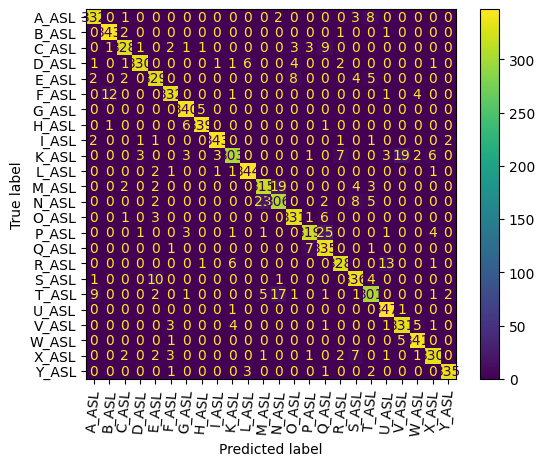

In [13]:
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = class_dict
cm = confusion_matrix(y_true,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp.plot(xticks_rotation=85)

  0%|          | 2/574 [05:09<24:36:13, 154.85s/it]


ValueError: x and y must have same first dimension, but have shapes (9,) and (11,)

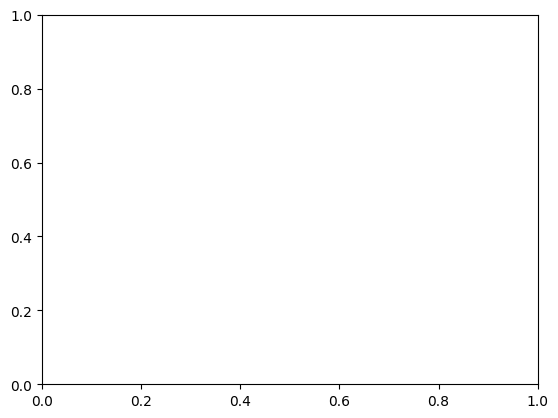

In [19]:
import matplotlib.pyplot as plt

loss = { "loss": [dictionary["loss"] for dictionary in trainer.state.log_history if "loss" in dictionary], "epoch" : [dictionary["epoch"] for dictionary in trainer.state.log_history]}
plt.plot(loss["epoch"][:-4],loss["loss"], label = "Perdida de Entrenamiento")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Perdida a traves de las Epochs")
plt.show()
#plot_loss_curves(results)

TypeError: compute_loss() got an unexpected keyword argument 'return_outputs'

In [3]:
import torch
from transformers import TrainingArguments

# Define the path to the training arguments binary file
training_args_path = '../model/checkpoint-1291/training_args.bin'

# Load the training arguments using torch
training_args = torch.load(training_args_path)

# Access the batch sizes
train_batch_size = training_args.per_device_train_batch_size
eval_batch_size = training_args.per_device_eval_batch_size

print(f"Training batch size: {train_batch_size}")
print(f"Evaluation batch size: {eval_batch_size}")

FileNotFoundError: [Errno 2] No such file or directory: './results/training_args.bin'